# Basic notebook for benchmarking tribus results

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from os import listdir
from os.path import isfile, join
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from umap import UMAP
import math

/Users/farateod/Documents/GitHub/tribus/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
palette = sns.dark_palette("#FF0000", as_cmap=True)
matplotlib.cm.register_cmap("mycolormap", palette)

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_66494/3647580927.py:2: UserWarning: Trying to register the cmap 'mycolormap' which already exists.
  matplotlib.cm.register_cmap("mycolormap", palette)


## Change these parameters

In [2]:
sample_name = 'tma_cores'
date = '2022-06-14_14-29'
level = 'Global'

## Get the input data

### File paths

In [3]:
#TODO documentation about files
sample_path = f'../tests/{sample_name}/quantification/'
cell_type_path = f'../tests/{sample_name}/cell_type_calling/cell_type_descriptions.xlsx'
labels_path = f'../tests/{sample_name}/cell_type_calling/{date}/'

### Read files

In [4]:
cell_type_description = pd.read_excel(cell_type_path, sheet_name=level)
all_markers = list(cell_type_description['Marker'])
cell_type_description = cell_type_description.set_index('Marker')
filtered_markers = list(cell_type_description.loc[(cell_type_description!=0).any(axis=1)].index)

In [5]:
samples = [f for f in listdir(sample_path) if isfile(join(sample_path, f))]
nr_of_samples = len(samples)
#TODO skip hidden files while iterate through the folder

In [27]:
all_samples = []
filtered_samples = []
cell_type_subsets = []
cell_type_subsets_filtered = []
all_cell_types = []
for sample in samples:
    #reading the sample and the result file
    sample_file = pd.read_csv(sample_path + sample)
    sample_file = sample_file[all_markers]
    labels = pd.read_csv(f'{labels_path}/labels_{sample}', header=None).loc[:,0]

    #filtering the sample file by used markers and use the result in the sample dataframe
    sample_file.loc[:, 'labels'] = labels
    filtered_sample = sample_file[[*filtered_markers, 'labels']]

    #add the sample into the samples list
    all_samples.append(sample_file)
    filtered_samples.append(filtered_sample)

    #subsetting the sample by cell types (labels)
    subsets_all = []
    subsets_filtered = []
    cell_types = list(np.unique(labels))
    for cell_type in cell_types:
        subsets_all.append(sample_file.loc[sample_file['labels'] == cell_type])
        subsets_filtered.append(filtered_sample.loc[filtered_sample['labels'] == cell_type])

    cell_type_subsets.append(subsets_all)
    cell_type_subsets_filtered.append(subsets_filtered)
    all_cell_types.append(cell_types)

## Correlation matrices

In [28]:
def get_correlation_matrix(table, markers):
    correlation_mx = pd.DataFrame()
    for marker1 in markers:
        correlations = []
        for marker2 in markers:
            correlations.append(np.corrcoef(list(table[marker1]), list(table[marker2]))[0, 1])
        correlation_mx[marker1] = correlations
    correlation_mx.index = markers
    return correlation_mx

In [29]:
def vis_corr_mx_one_sample(sample, subsets, markers, cell_types, sample_name):
    whole_sample_corr_mx = get_correlation_matrix(sample, markers)
    clustermap = sns.clustermap(whole_sample_corr_mx, figsize=(10, 10), cmap='vlag').fig.suptitle(
        f'Whole sample correlation {sample_name}', fontweight="bold", y=1.01)

    corr_matrices = []
    for table in subsets:
        corr_matrices.append(get_correlation_matrix(table, markers))

    for i in range(len(corr_matrices)):
        clustermap = sns.clustermap(corr_matrices[i], figsize=(10, 10), cmap='vlag').fig.suptitle(f'{cell_types[i]} {sample_name}',fontweight="bold",y=1.01)

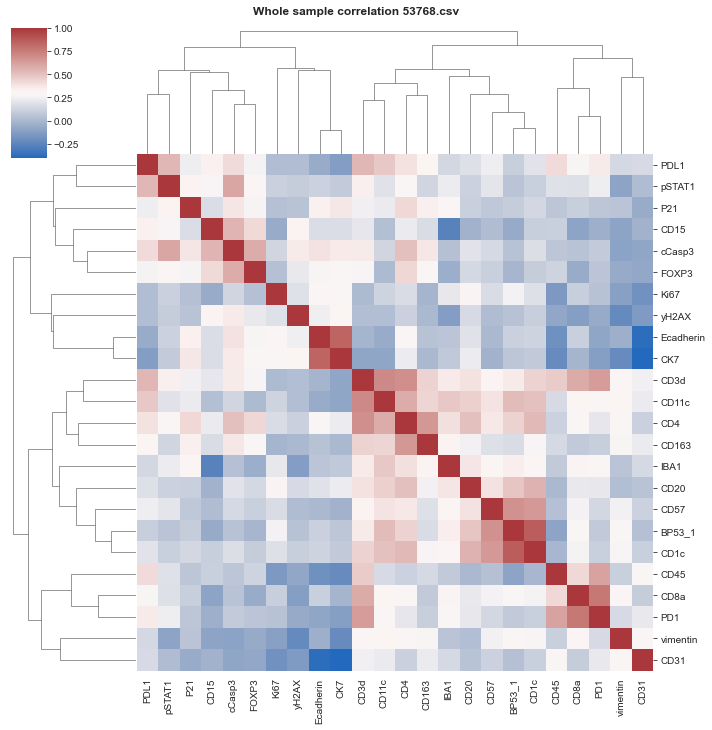

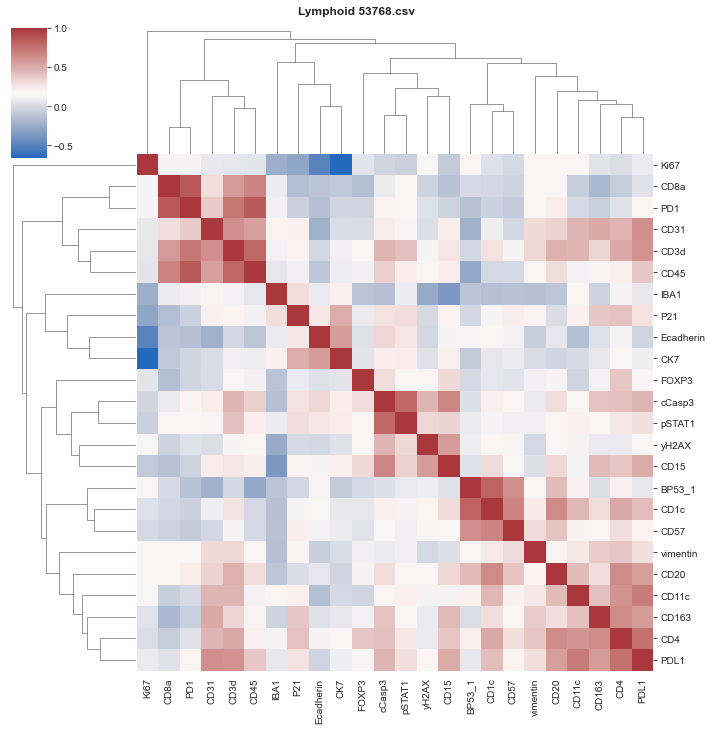

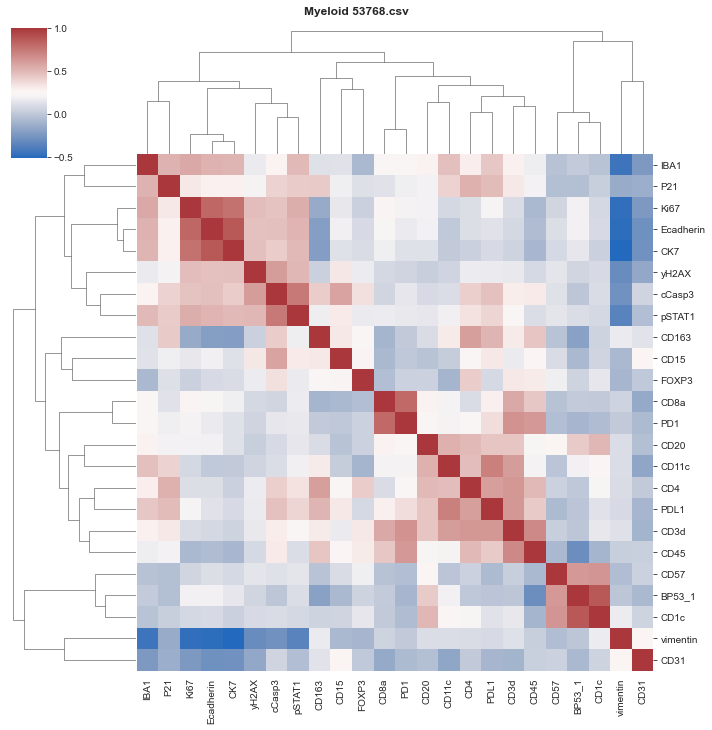

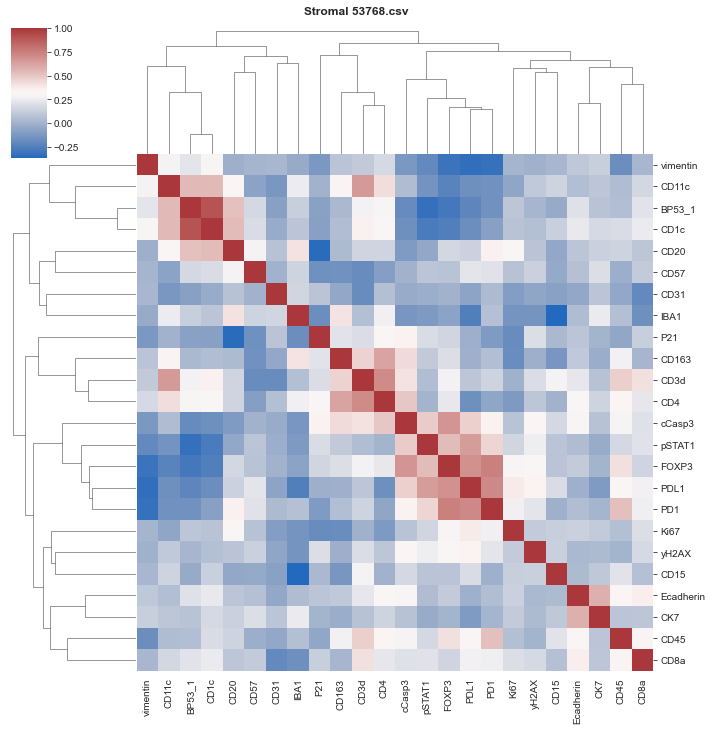

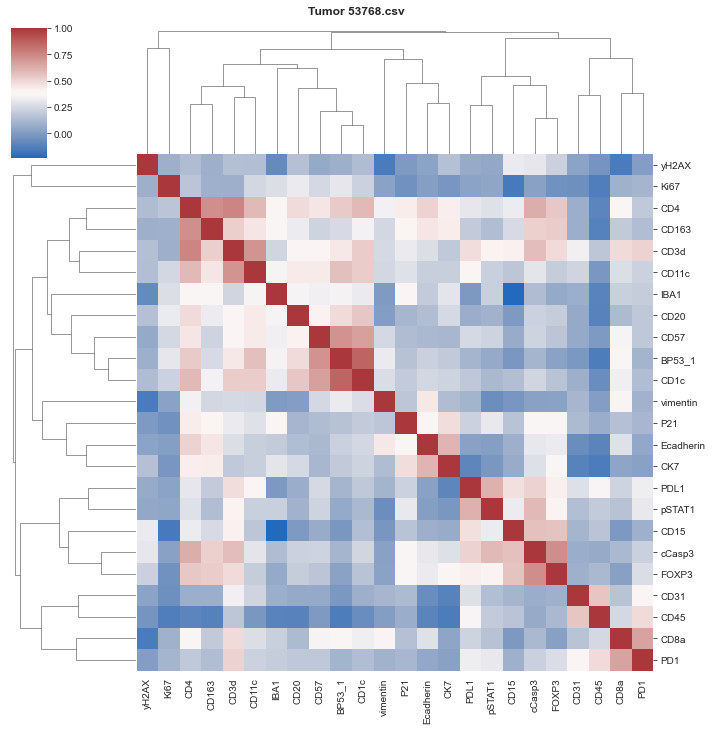

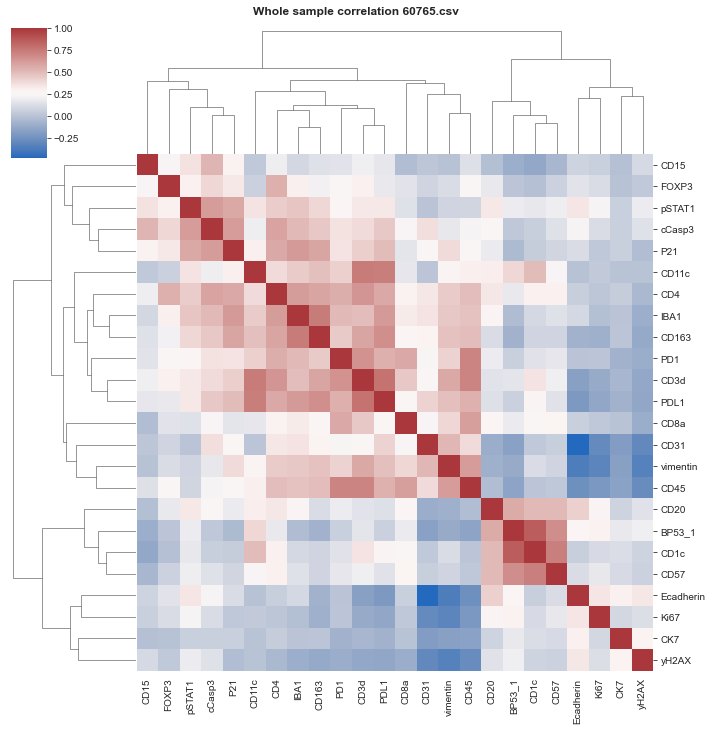

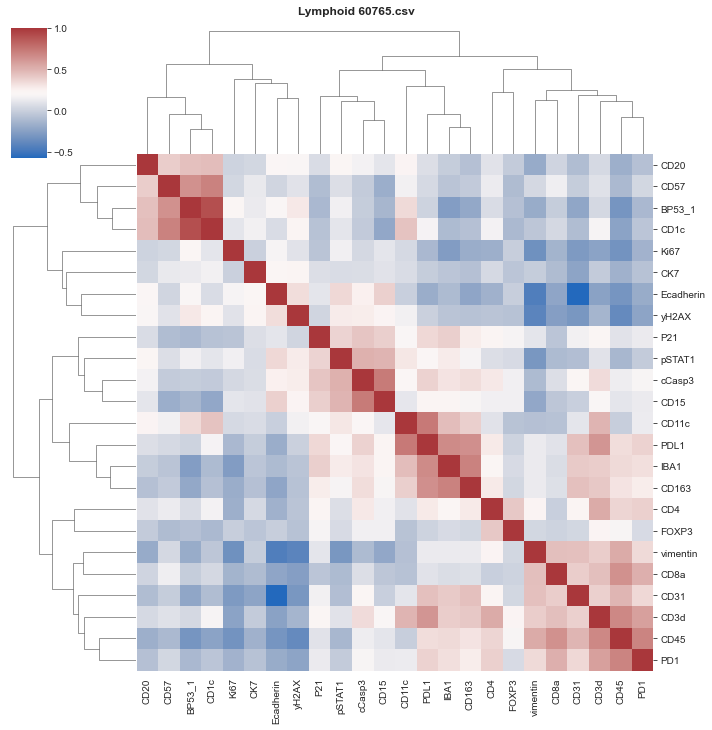

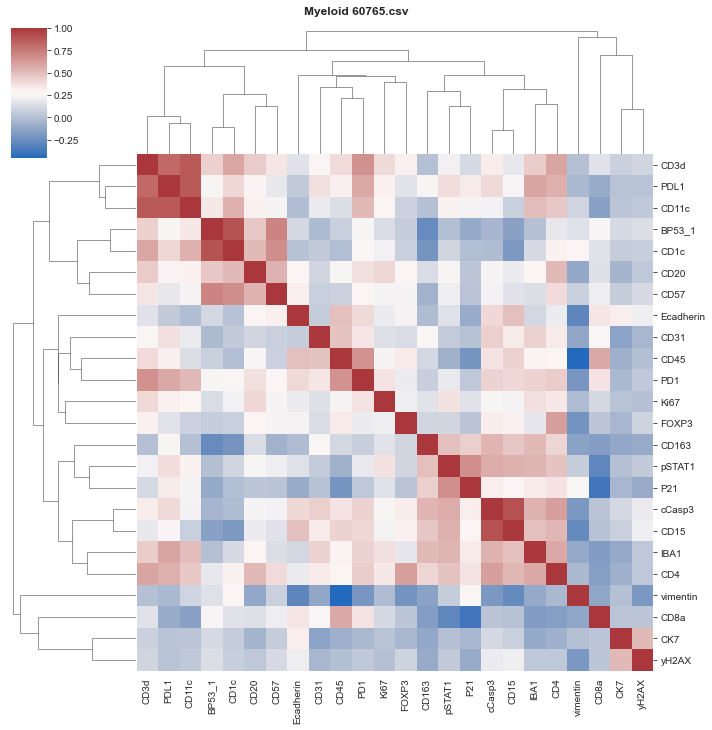

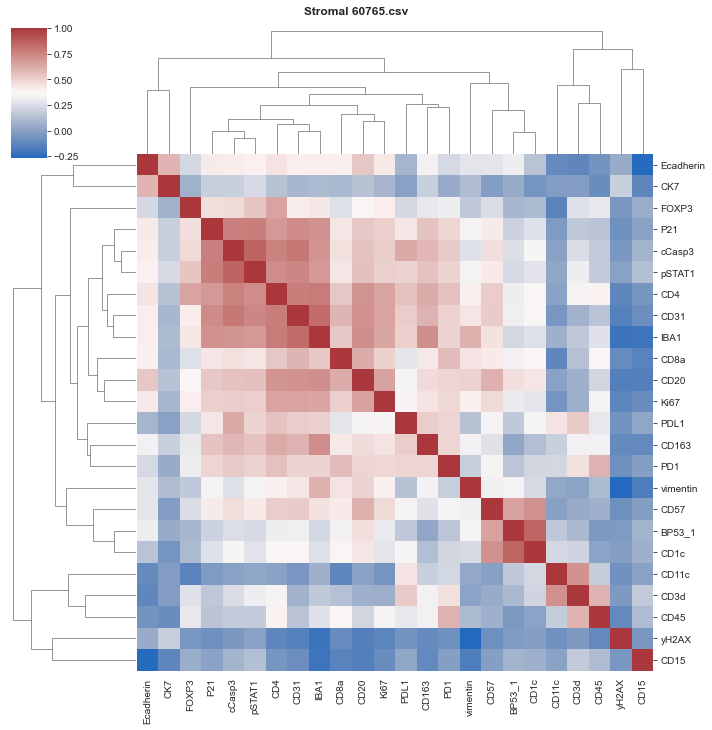

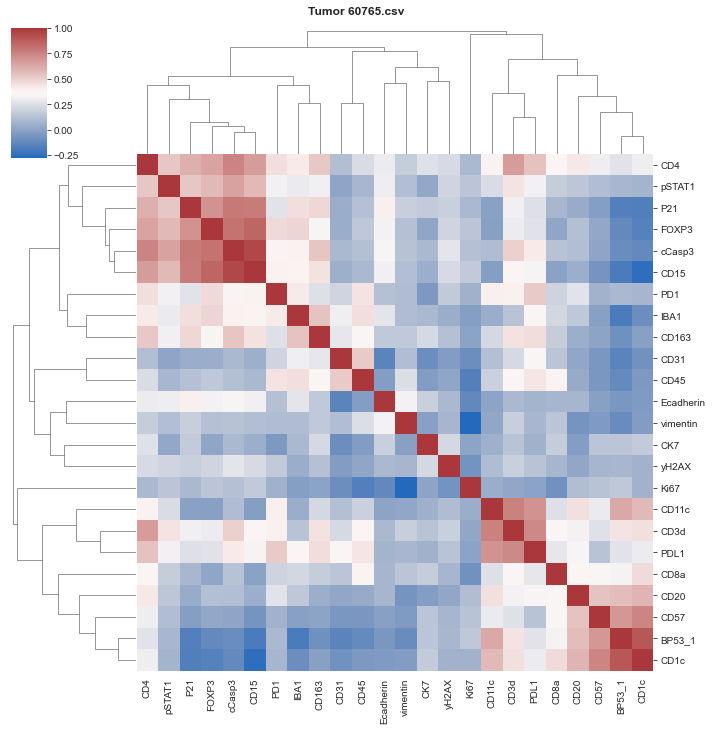

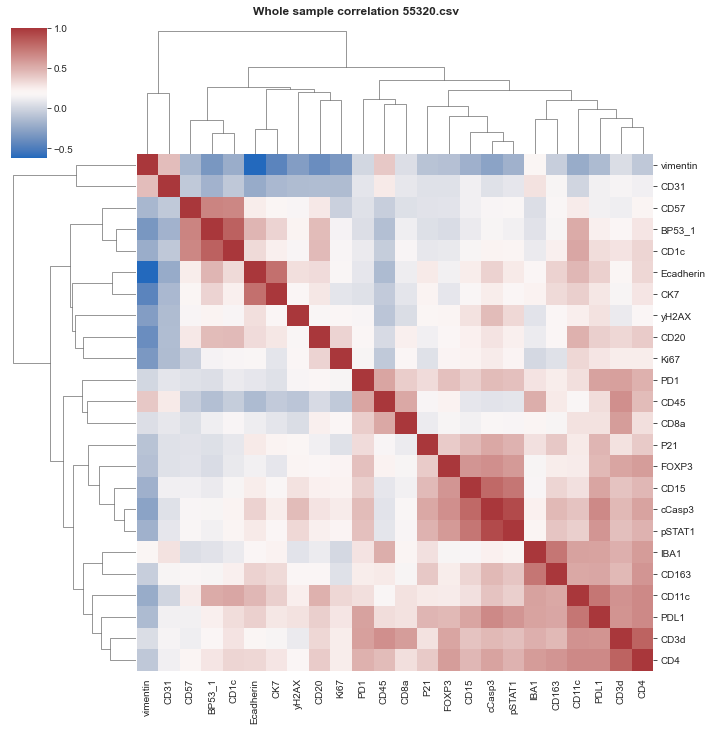

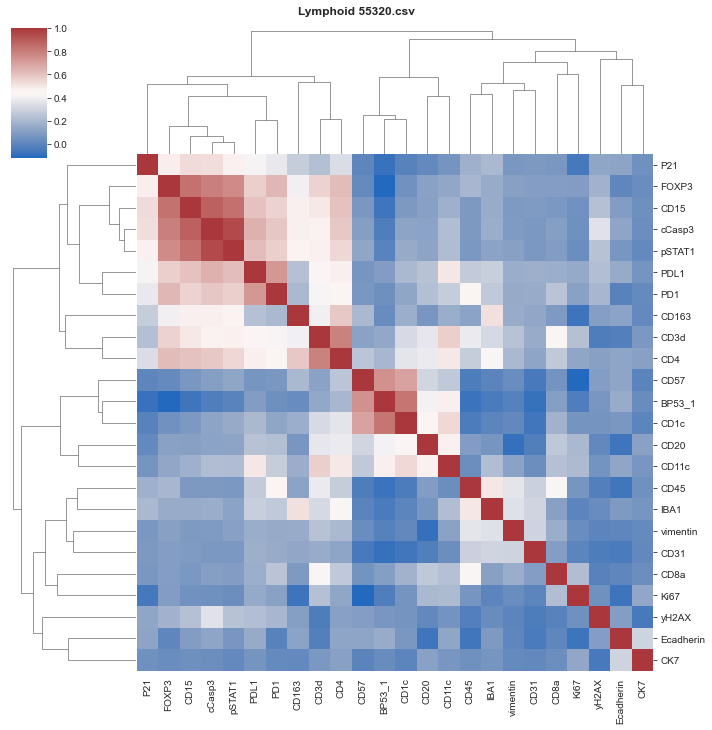

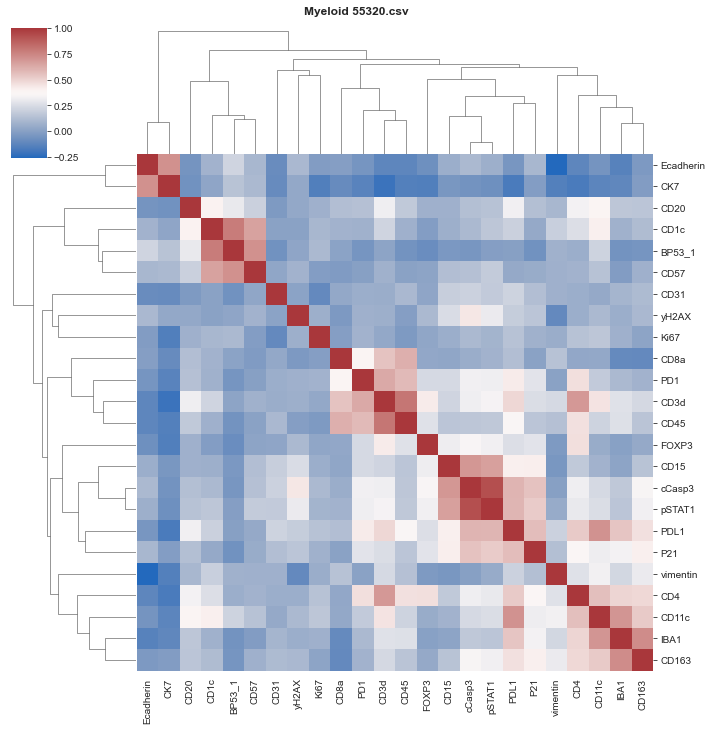

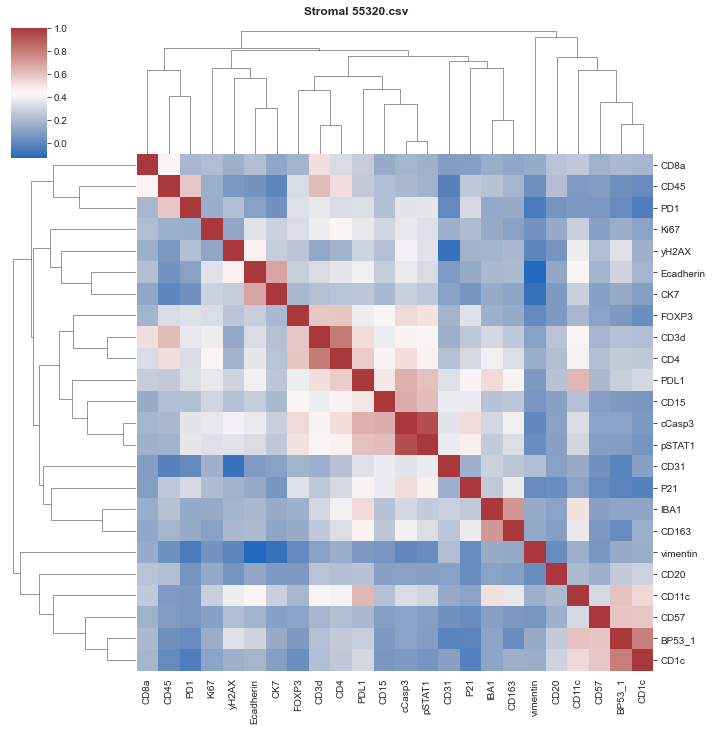

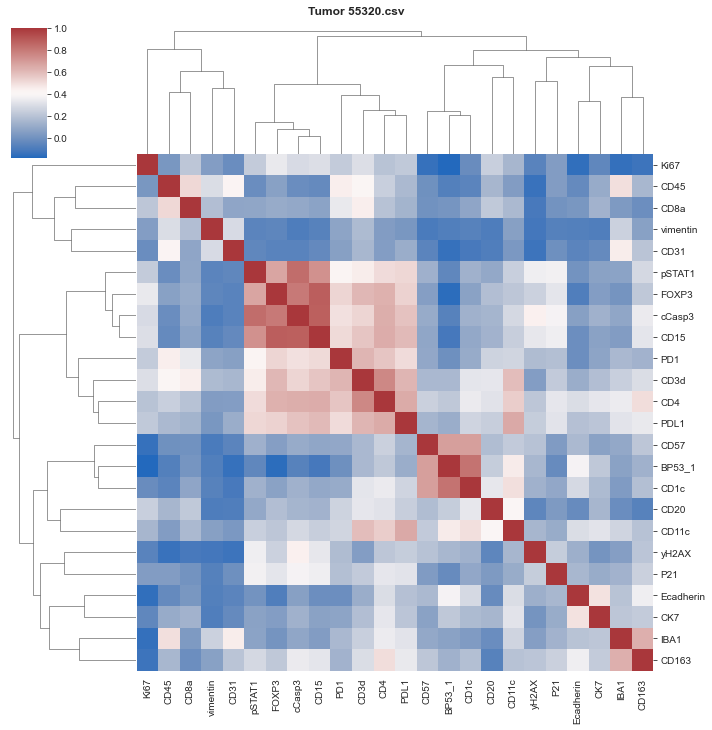

In [30]:
for i in range(nr_of_samples):
    vis_corr_mx_one_sample(all_samples[i], cell_type_subsets[i], all_markers, all_cell_types[i], samples[i])

## Heatmaps of marker expressions

In [33]:
def get_heatmap(tables, cell_types, sample_name):
    df_median = pd.DataFrame()
    for i in range(len(cell_types)):
        df_median[cell_types[i]] = tables[i].iloc[:,:-1].median()
    sns.clustermap(df_median.transpose(), figsize=(10, 5), cmap='vlag').fig.suptitle(sample_name,fontweight="bold", y=1.01)

### Raw data

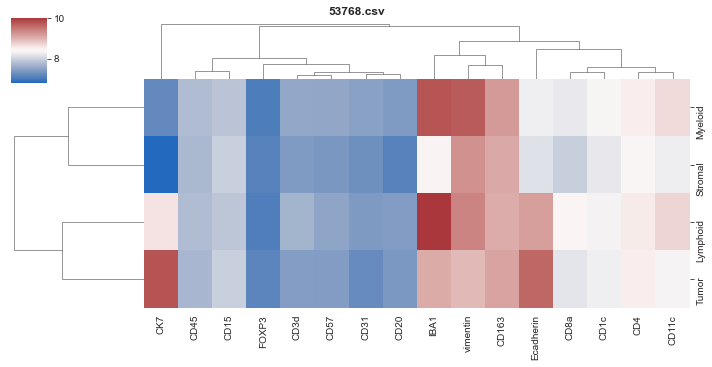

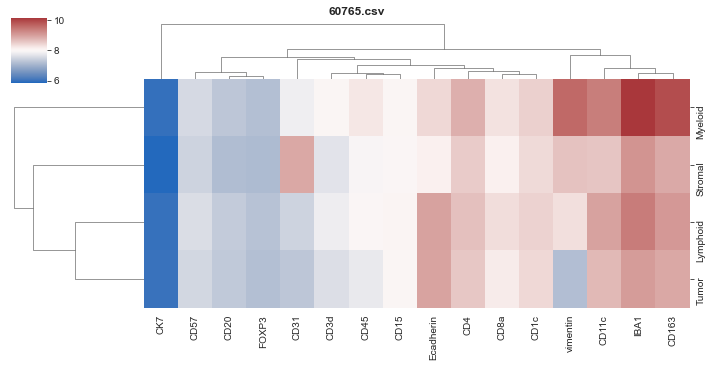

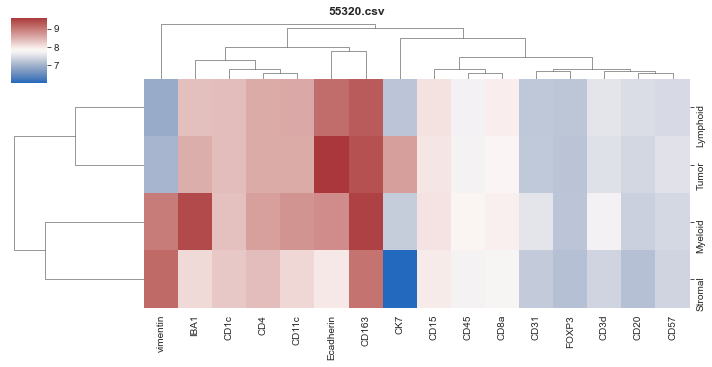

In [34]:
for i in range(nr_of_samples):
    get_heatmap(cell_type_subsets_filtered[i], all_cell_types[i], samples[i] )

### Z-score transformation

In [35]:
def z_score(df):
    z_scores = df.drop(['labels'], axis=1).apply(stats.zscore, axis = 1)
    z_scores['labels'] = df['labels']
    return z_scores

In [36]:
z_score_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(z_score(subset))
    z_score_subsets.append(subsets)

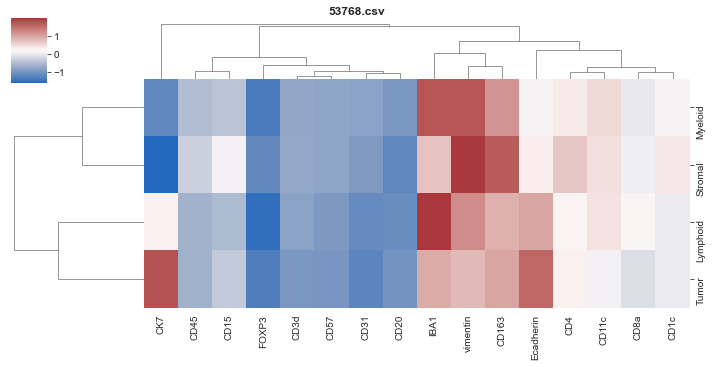

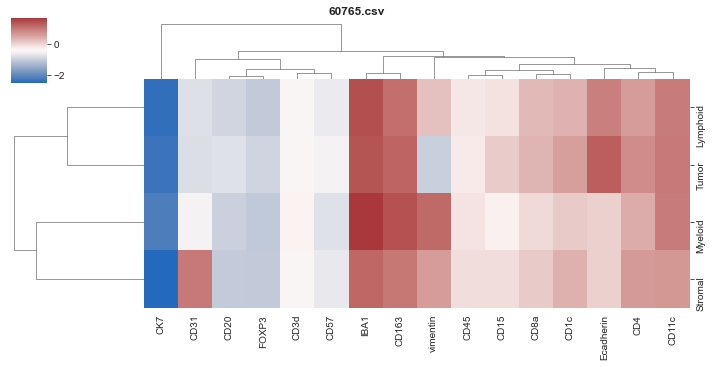

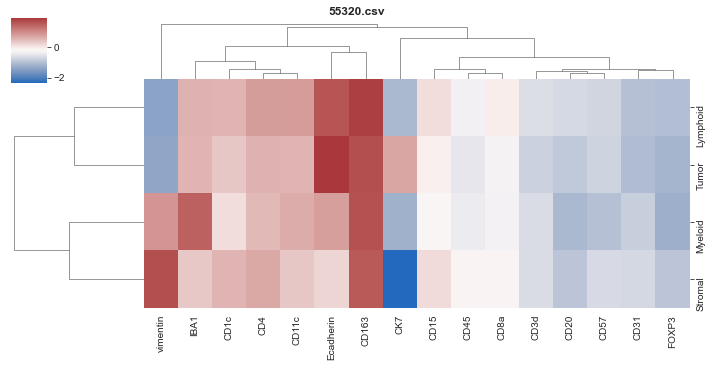

In [37]:
for i in range(nr_of_samples):
    get_heatmap(z_score_subsets[i], all_cell_types[i], samples[i] )

### 0-1 normalization

In [38]:
def zero_one(df):
    norm = df.drop(['labels'], axis = 1)
    norm = norm.div(norm.sum(axis=1), axis=0)
    norm['labels'] = df['labels']
    return norm

In [39]:
norm_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(zero_one(subset))
    norm_subsets.append(subsets)

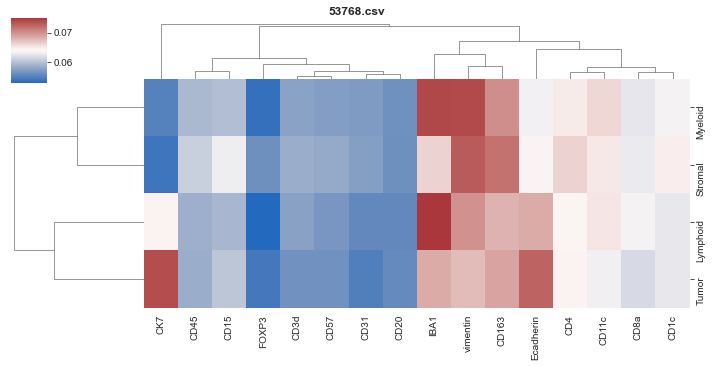

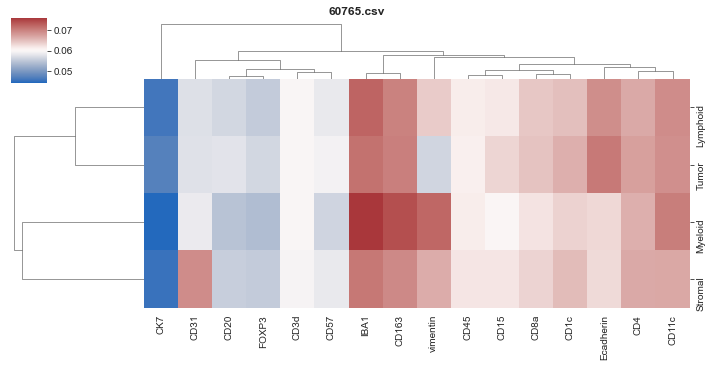

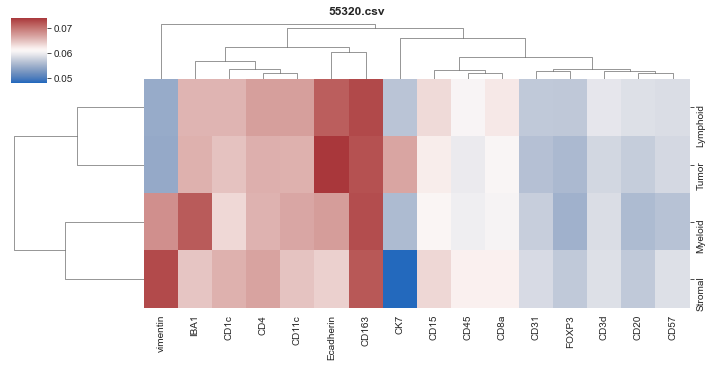

In [40]:
for i in range(nr_of_samples):
    get_heatmap(norm_subsets[i], all_cell_types[i], samples[i] )

### Standard scaler

In [41]:
def standard_scaler(df):
    table = df.drop(['labels'], axis = 1)
    standard = preprocessing.StandardScaler().fit_transform(table.transpose())
    res = pd.DataFrame(np.transpose(standard), columns= table.columns).set_index(table.index)
    res['labels'] = df['labels']
    return res

In [42]:
standard_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(standard_scaler(subset))
    standard_subsets.append(subsets)

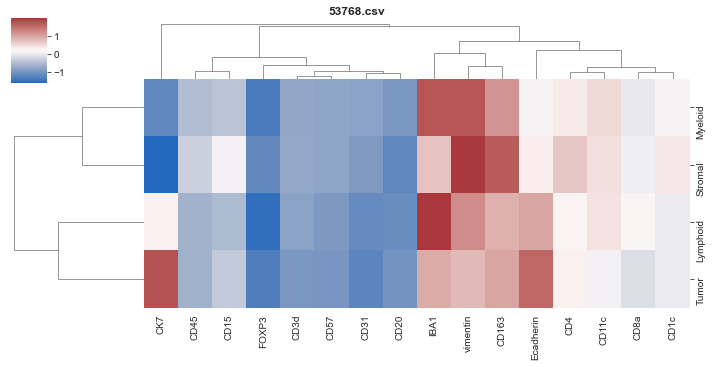

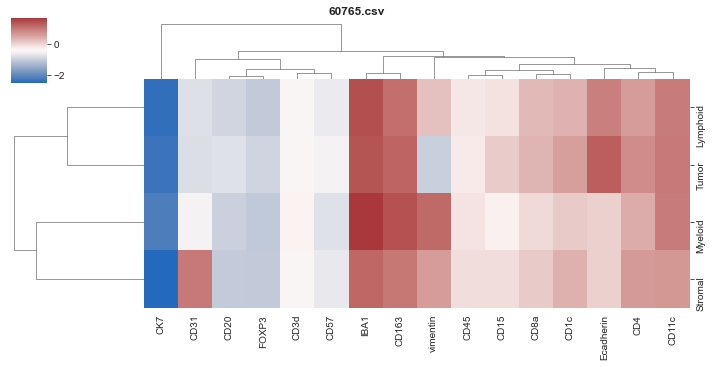

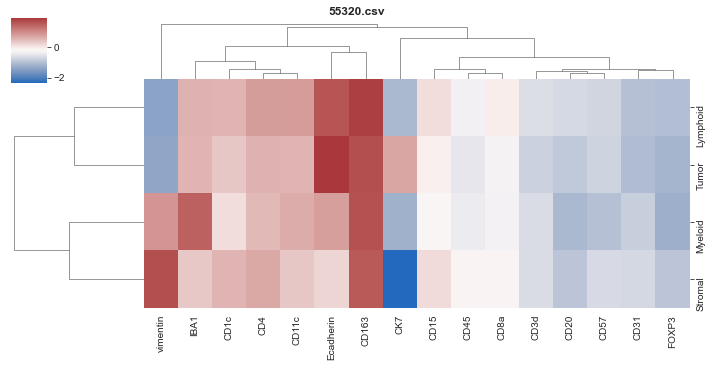

In [43]:
for i in range(nr_of_samples):
    get_heatmap(standard_subsets[i], all_cell_types[i], samples[i] )

### LogTransform

In [44]:
def log_transform(df):
    table = df.drop(['labels'], axis = 1)
    log = preprocessing.FunctionTransformer(np.log1p).fit_transform(table.transpose())
    res = pd.DataFrame(np.transpose(log), columns=table.columns).set_index(table.index)
    res['labels'] = df['labels']
    return res

In [45]:
log_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(log_transform(subset))
    log_subsets.append(subsets)

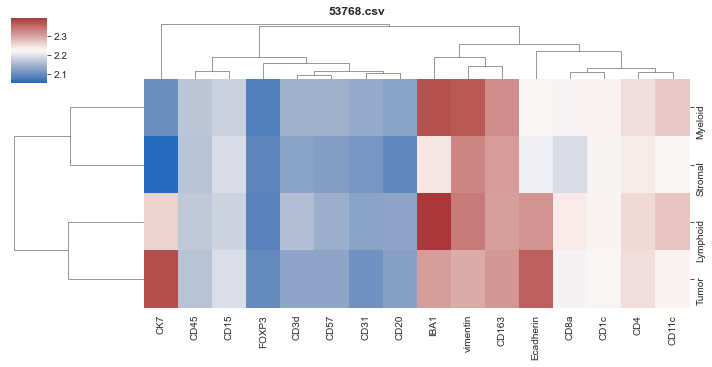

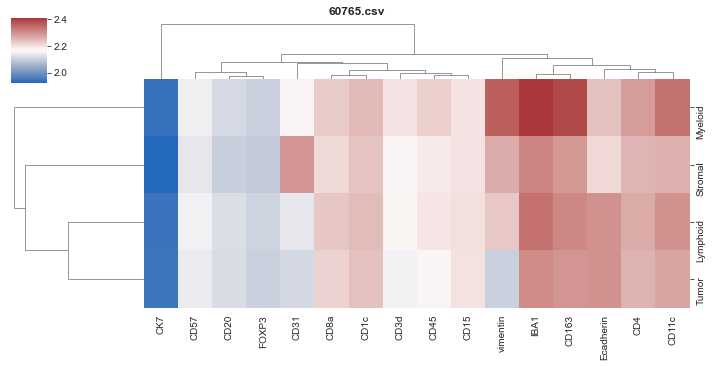

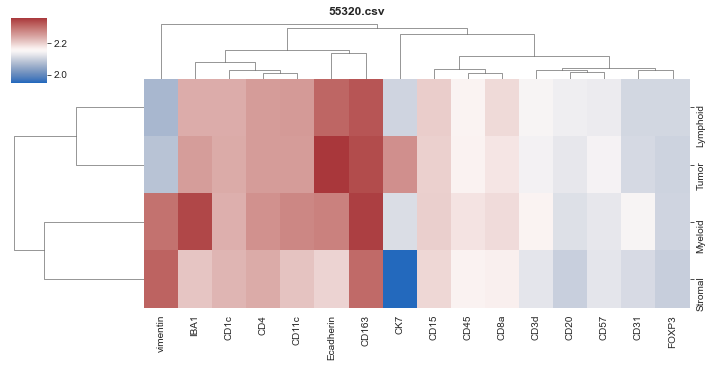

In [46]:
for i in range(nr_of_samples):
    get_heatmap(log_subsets[i], all_cell_types[i], samples[i] )

### LogTransfrom & StandardScaler

In [47]:
def log_standard(df):
    table = df.drop(['labels'], axis = 1)
    log = preprocessing.FunctionTransformer(np.log1p).fit_transform(table.transpose())
    log = preprocessing.StandardScaler().fit_transform(log)
    res = pd.DataFrame(np.transpose(log), columns=table.columns).set_index(table.index)
    res['labels'] = df['labels']
    return res

In [48]:
log_standard_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(log_standard(subset))
    log_standard_subsets.append(subsets)

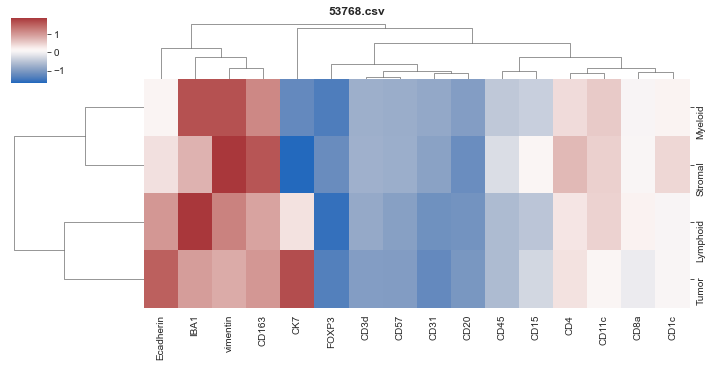

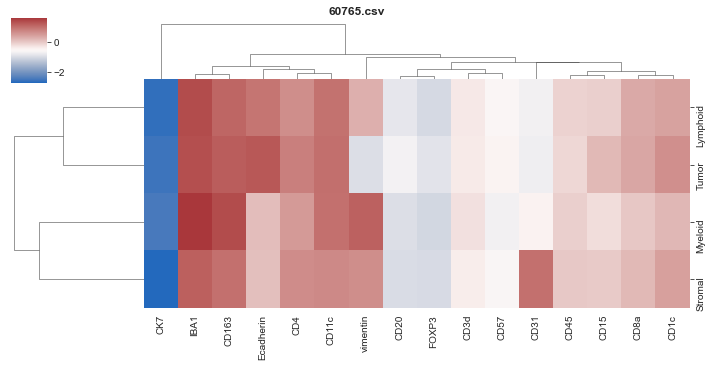

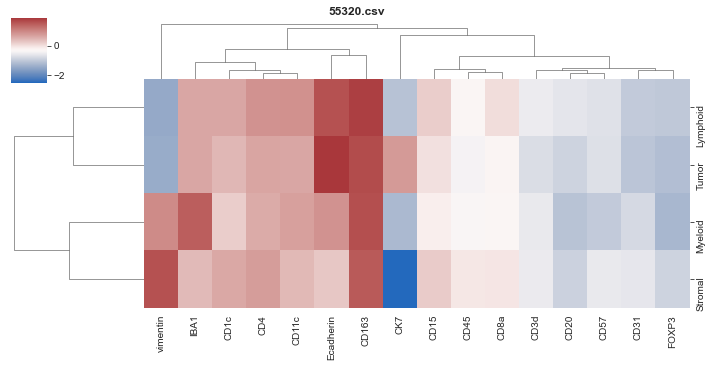

In [49]:
for i in range(nr_of_samples):
    get_heatmap(log_standard_subsets[i], all_cell_types[i], samples[i] )

## T-SNE/UMAP

In [56]:
def no_trans(table):
    return table

In [57]:
def do_tsne(table, transformation, init, metric, n_iter, perplexity, learning_rate, title):
    markers = table.columns
    features = transformation(table)
    features = features.drop(['labels'], axis = 1)
    tsne = pd.DataFrame(
        data = TSNE(n_components = 2, init = init, metric = metric, n_iter= n_iter, perplexity= perplexity, learning_rate= learning_rate).fit_transform(features), columns = ["component 1", "component 2"])

    columns = math.ceil(len(markers)/3)
    fig, ax = plt.subplots(3, columns, figsize = (22, 16))
    fig.suptitle(title, fontsize=30)

    for i in range(len(markers)):
        tsne[markers[i]] = table[markers[i]]
        sns.scatterplot(data = tsne, x = "component 1", y = "component 2", ax = ax[int(i/columns)][i%columns], alpha = 0.8, hue = markers[i], palette='mycolormap')

/Users/farateod/Documents/GitHub/tribus/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/farateod/Documents/GitHub/tribus/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/farateod/Documents/GitHub/tribus/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


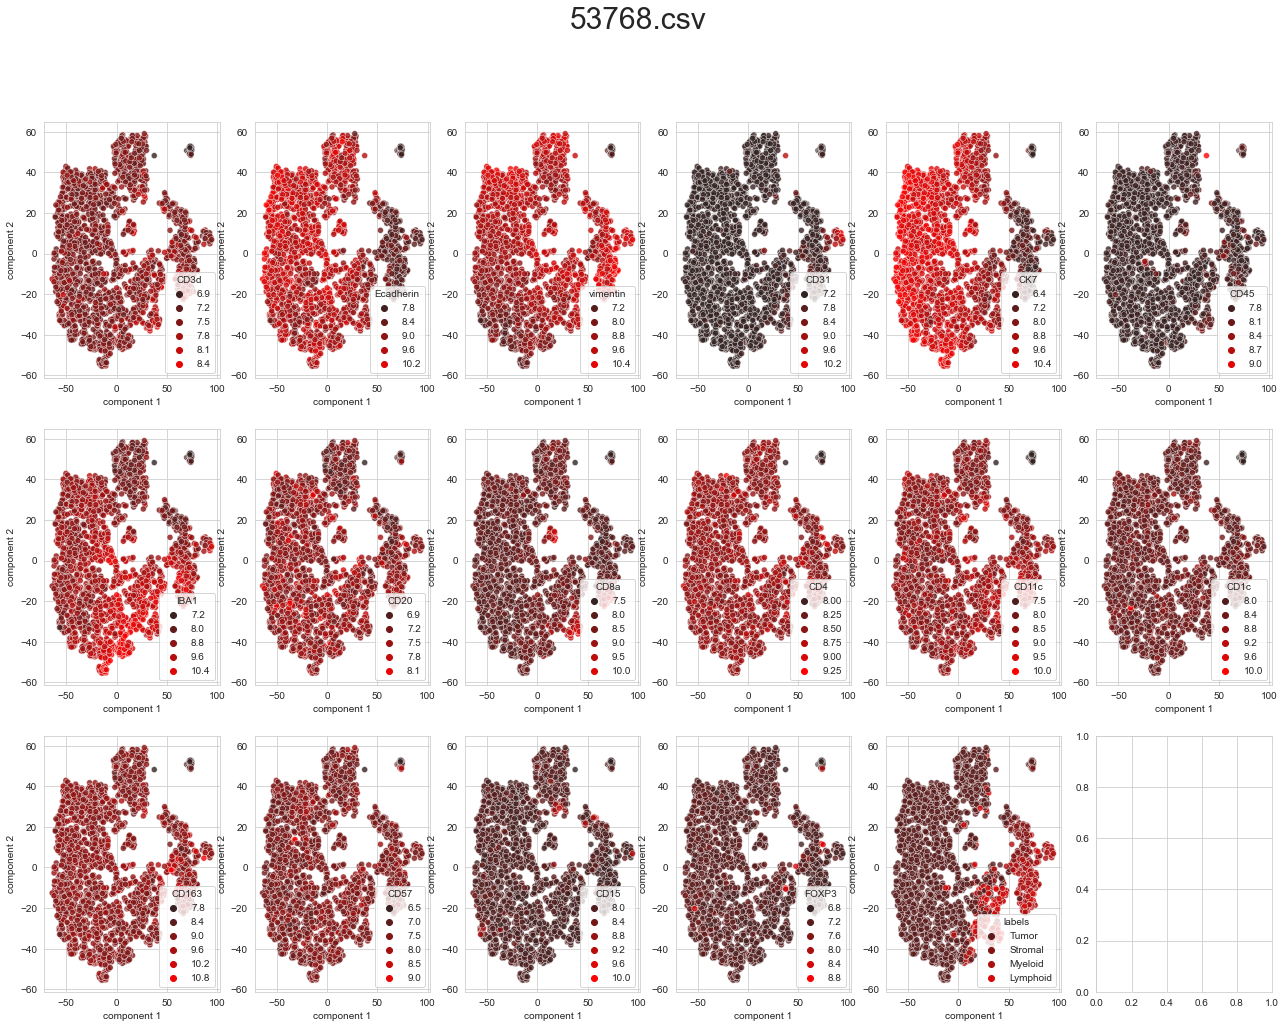

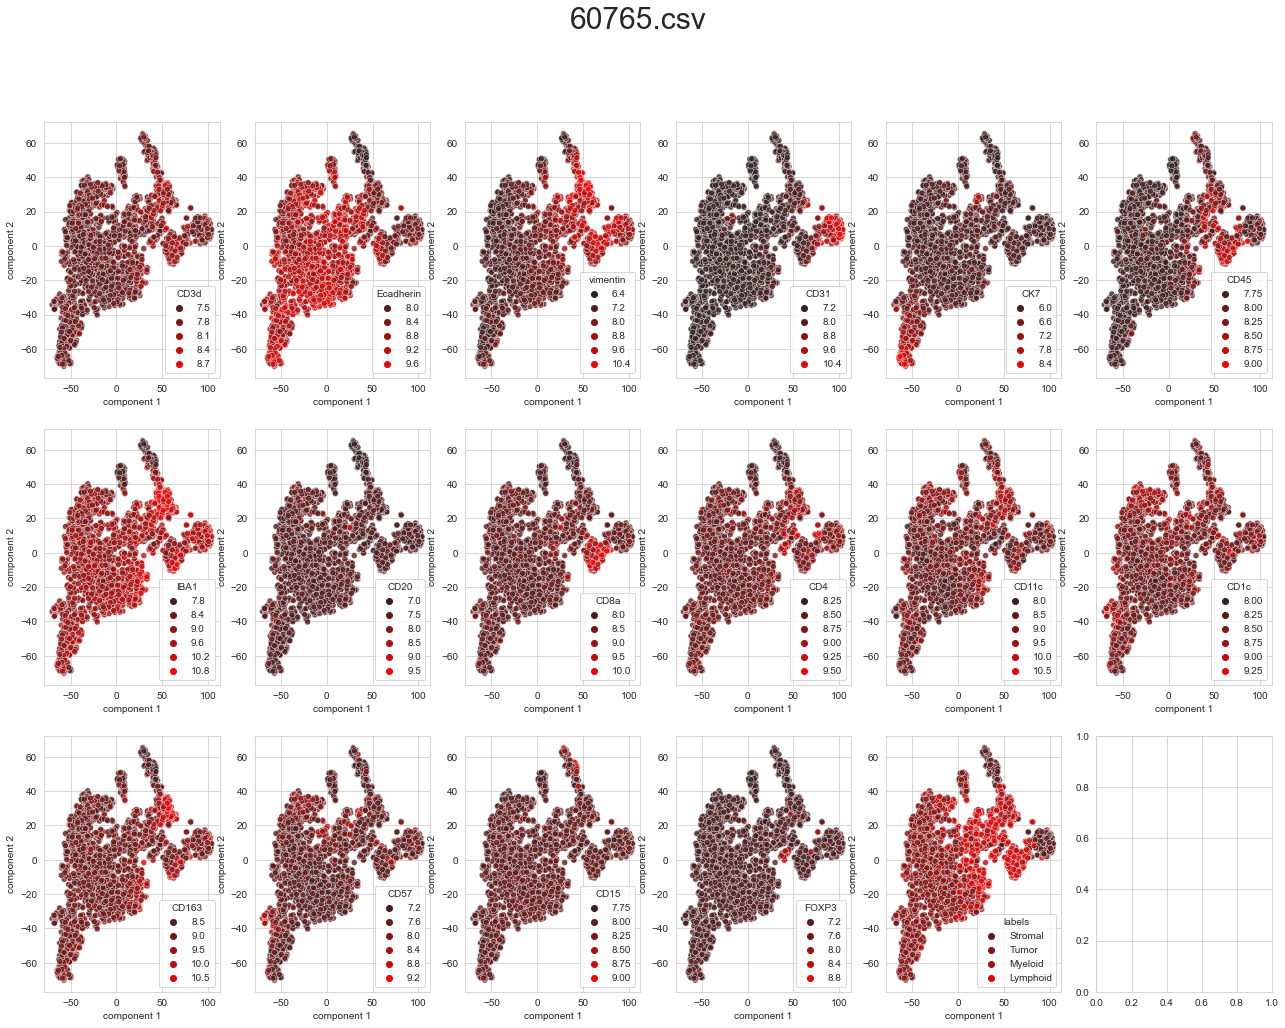

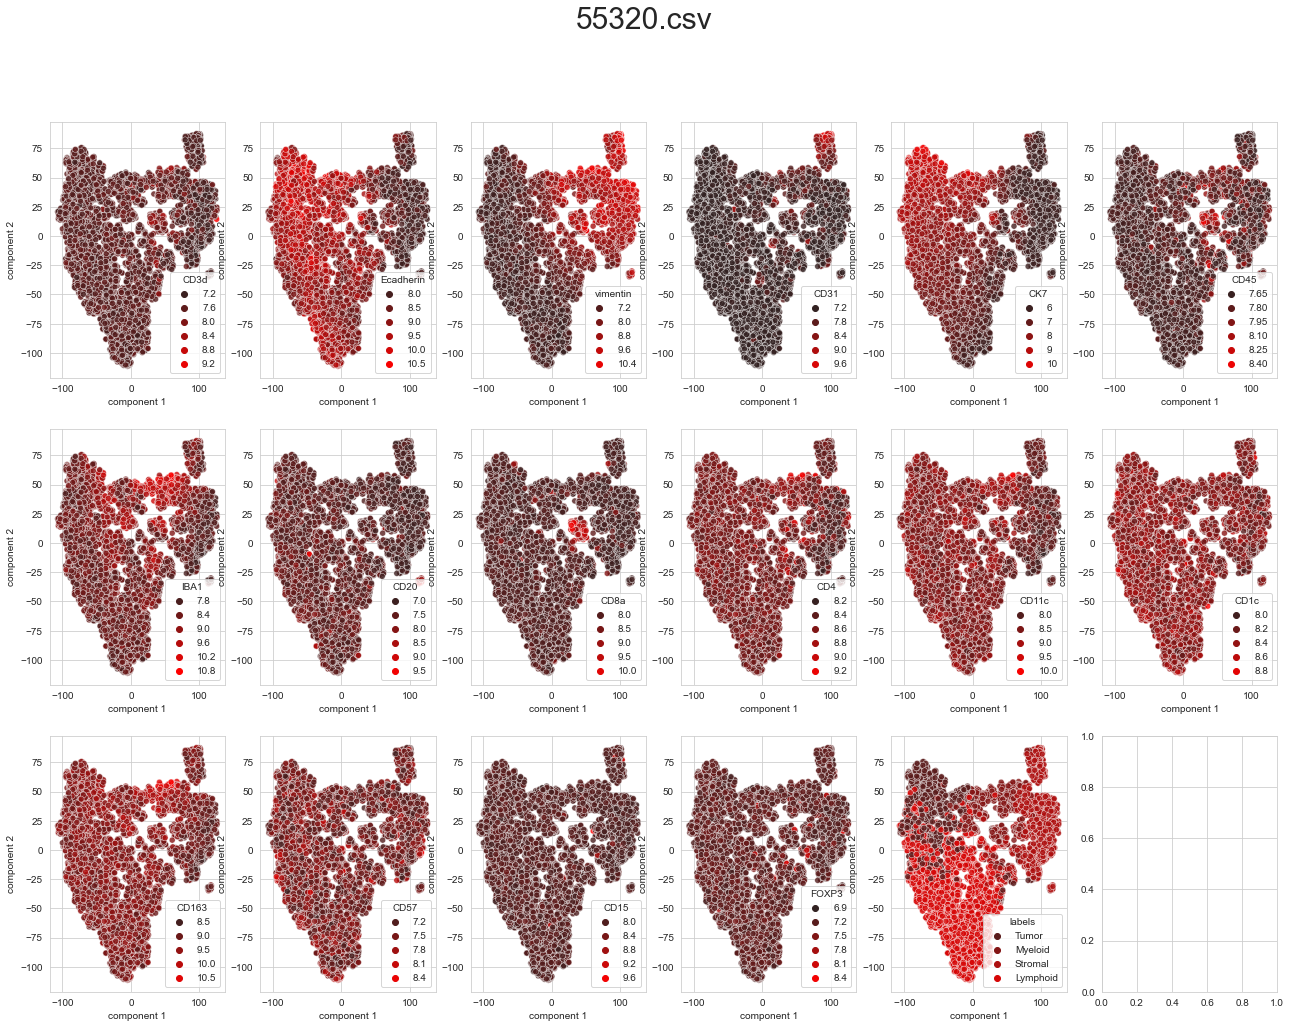

In [58]:
for i in range(nr_of_samples):
    do_tsne(filtered_samples[i], no_trans, 'pca', metric='cosine',  n_iter= 10000, perplexity= 25, learning_rate= 450, title = samples[i])

## UMAP

In [59]:
def do_umap(table, transformation, title, n_components=2, init='spectral', random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation'):
    markers = table.columns
    features = transformation(table)
    features = features.drop(['labels'], axis = 1)

    proj_2d = pd.DataFrame(data = UMAP(n_components=n_components, init=init, random_state=random_state, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric).fit_transform(features), columns = ["component 1", "component 2"])
    columns = math.ceil(len(markers)/3)
    fig, ax = plt.subplots(3, columns, figsize = (22, 16))
    fig.suptitle(title, fontsize=30)

    for i in range(len(markers)):

        proj_2d[markers[i]] = table[markers[i]]

        sns.scatterplot(data = proj_2d, x = "component 1", y = "component 2", ax = ax[int(i/columns)][i%columns], alpha = 0.8, hue = markers[i], palette = 'mycolormap' )

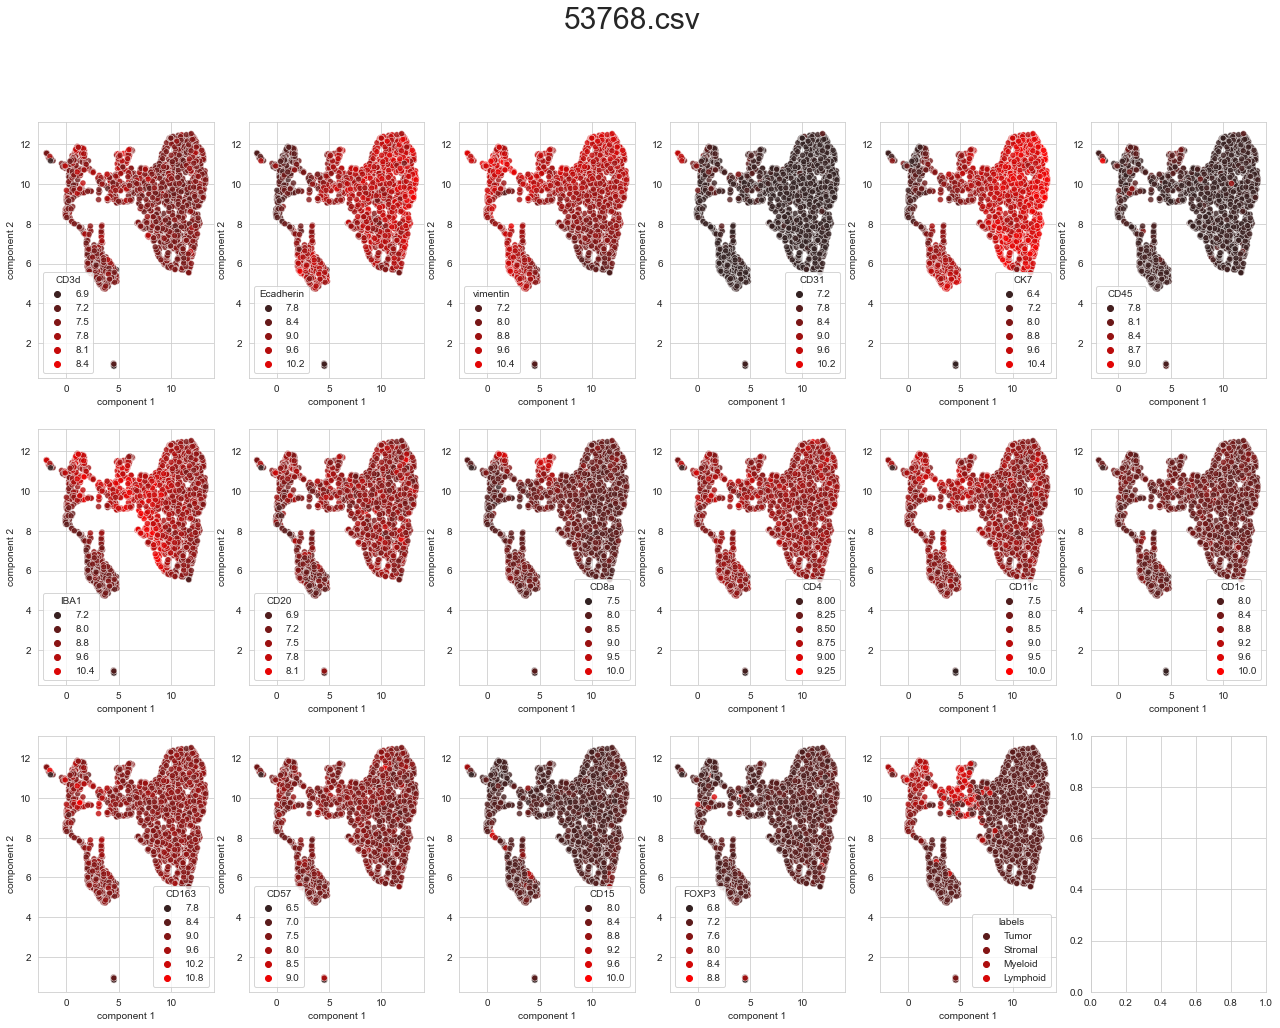

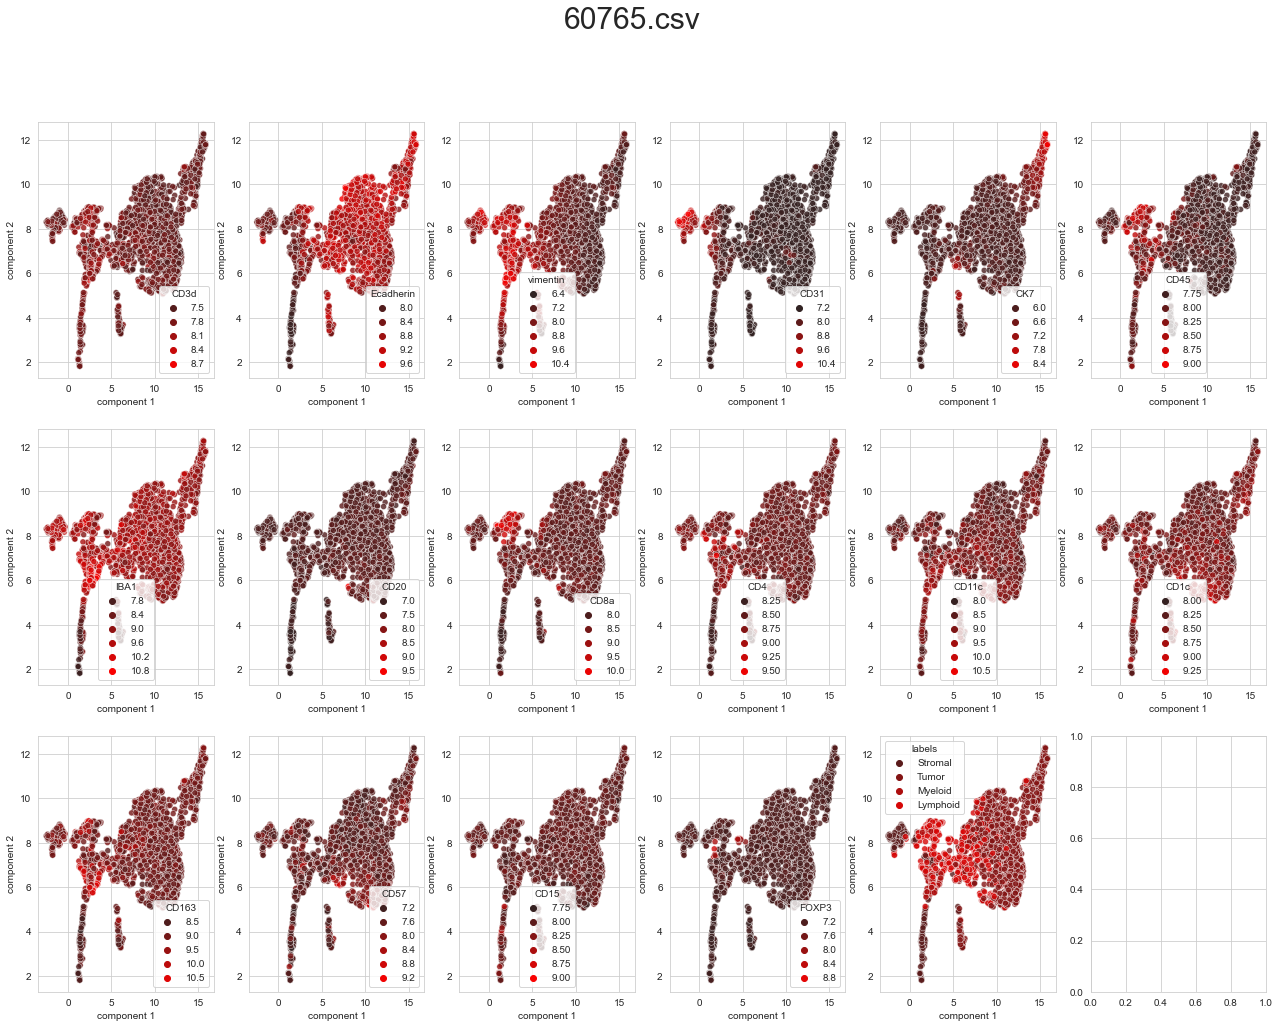

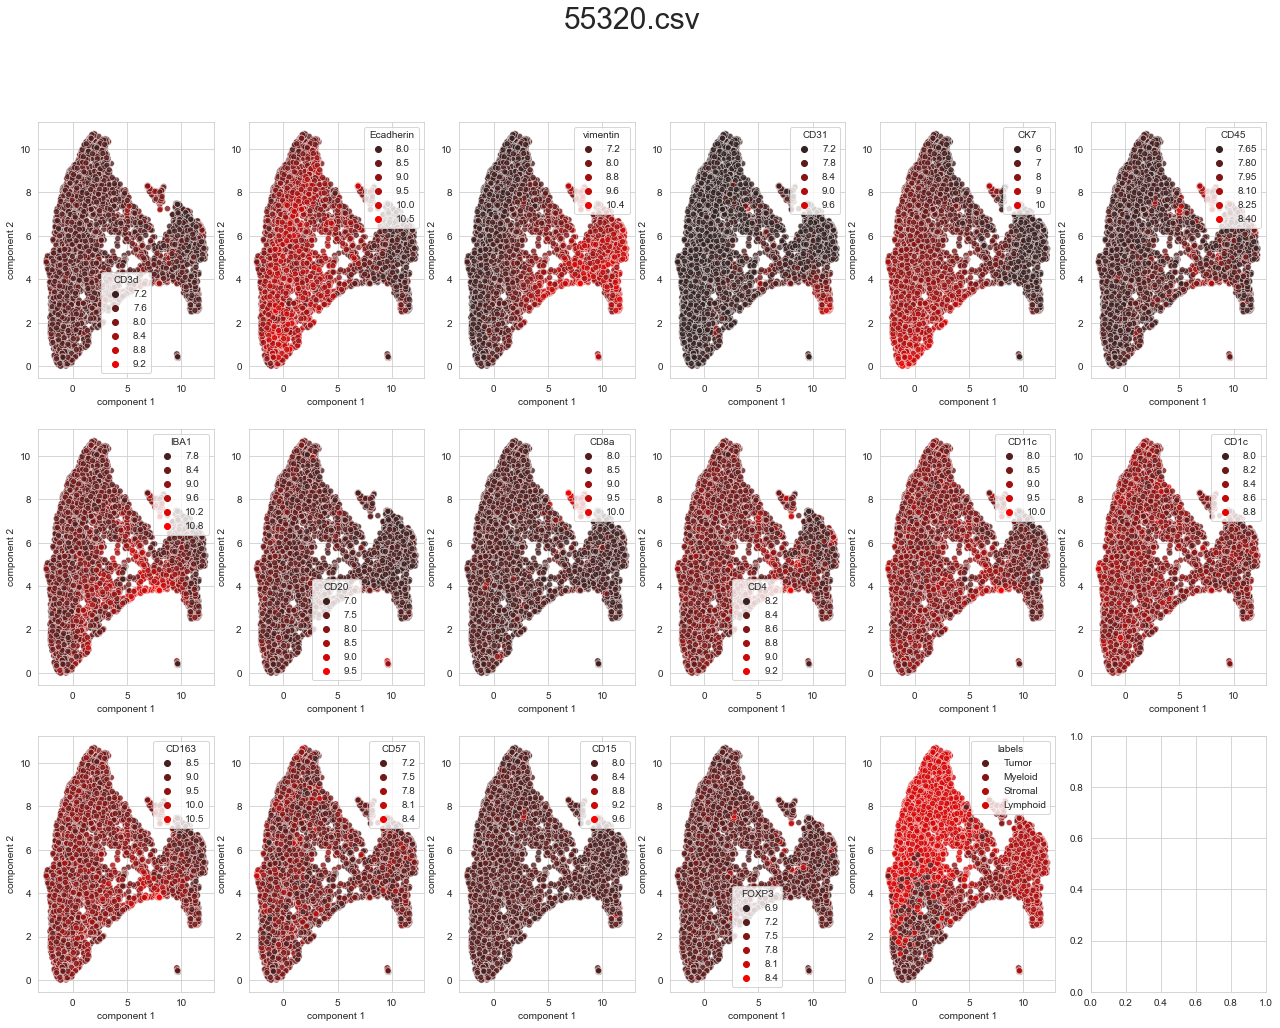

In [60]:
for i in range(nr_of_samples):
    do_umap(filtered_samples[i], log_transform, title=samples[i])